! pip install tqdm


In [3]:
# Load Libraries
import os
import glob
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from tqdm import tqdm

In [68]:
# Data preprocessing
# Data preprocessing
augment_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((256, 256)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/'

def skipping_stride(images_dir, window_size=10, stride=1):
    images = sorted(glob.glob(os.path.join(images_dir, '*.tif')))
    sequences = []
    # if we are predicting LSTM images then should not multiply 
    for start in range(0, len(images), stride * window_size):
        window = images[start: start + stride * window_size:stride]
        sequence = [augment_transforms(default_loader(f)) for f in window]
        sequence_tensor = torch.stack(sequence, dim=0)
        sequences.append(sequence_tensor)
    return sequences

data = []

for subfolder in tqdm(sorted(os.listdir(root_dir)), desc="Processing Subfolders"):
    folder_path = os.path.join(root_dir, subfolder)
    for stride_value in [1,2]:
        sequences = skipping_stride(folder_path, stride=stride_value)
        if sequences:
            data.extend(sequences)


data_tensor = torch.stack(data, dim=0)
print(data_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Processing Subfolders: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:13<00:00,  2.45it/s]

torch.Size([1020, 10, 1, 256, 256])


In [48]:
# gereate dataset for training and testing

data_tensor = torch.stack(data, dim=0)
print(data_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Testing the dataset
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# view some images 
def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

torch.Size([1020, 10, 1, 256, 256])


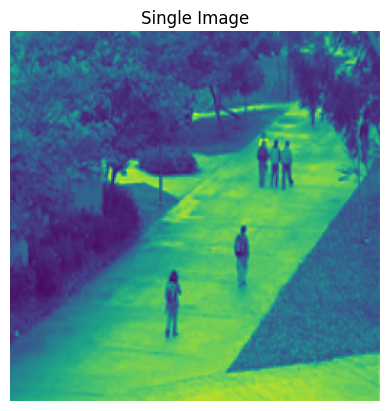

In [206]:
# Fetch the next batch
batch = next(train_loader_iter)  
plot_image_tensor(batch[0][0][0])  # Plot the first image from the batch

In [26]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.gates = nn.Conv2d(in_channels=input_channels + hidden_channels,
                               out_channels=4 * hidden_channels,  # for input, forget, cell, and output gates
                               kernel_size=kernel_size,
                               padding=self.padding)

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        # print("[input_tensor, h_cur]", [input_tensor.size(), h_cur.size()])
        # concatenate along the channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        gates = self.gates(combined)

        # Split the combined gate tensor into its components
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        c_next = forget_gate * c_cur + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device))


class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        # Spatial Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=11, stride=4, padding=(11-1)//2),
            nn.BatchNorm2d(128),
            nn.ReLU(),  # Assuming you want a ReLU activation after BatchNorm
            nn.Dropout(0.5),
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=(5-1)//2),
            nn.BatchNorm2d(64),
            nn.ReLU(),  # Assuming you want a ReLU activation after BatchNorm
            nn.Dropout(0.5)
        )
        # Temporal Bottleneck (ConvLSTM)
        self.convlstm1 = ConvLSTMCell(input_channels=64, hidden_channels=64, kernel_size=3)
        self.convlstm2 = ConvLSTMCell( input_channels=64, hidden_channels=32, kernel_size=3)
        self.convlstm3 = ConvLSTMCell( input_channels=32, hidden_channels=64, kernel_size=3)
        
        # Spatial Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),  # Assuming you want a ReLU activation after BatchNorm
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=12, stride=4, padding=4, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),  # Assuming you want a ReLU activation after BatchNorm
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=11, padding=(11-1)//2)
        )
    def forward(self, x):
        # Initialize hidden states and cell states
        b, seq_len, _, h, w = x.size()
        # print("x.size()", x.size())
        h1, c1 = self.convlstm1.init_hidden(b, (h//8, w//8))
        h2, c2 = self.convlstm2.init_hidden(b, (h//8, w//8))
        h3, c3 = self.convlstm3.init_hidden(b, (h//8, w//8))
        output_sequence = []

        for t in range(seq_len):
            # Spatial Encoder
            xt = self.encoder(x[:, t])

            # Temporal Encoder
            h1, c1 = self.convlstm1(xt, (h1, c1))
            h2, c2 = self.convlstm2(h1, (h2, c2))
            h3, c3 = self.convlstm3(h2, (h3, c3))

            # Spatial Decoder
            xt = self.decoder(xt) 

            xt = torch.sigmoid(xt)

            output_sequence.append(xt.unsqueeze(1))

        # Concatenate along the sequence dimension

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence
# Example usage
model = ConvLSTM()
image = torch.randn(1, 10, 1, 256, 256)
output = model(image)
print(output.size())

torch.Size([1, 10, 1, 256, 256])


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"train_loader.dataset: {len(train_loader.dataset)}")
print(f"val_loader.dataset: {len(val_loader.dataset)}")

model = ConvLSTM()  # Assuming ConvLSTM is defined elsewhere
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-6, weight_decay=1e-5)

# Early stopping parameters
patience = 15
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model_less.pth'

# To store loss statistics
train_losses = []
val_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for (images,) in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}')

    # Early stopping check and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


cuda


NameError: name 'train_dataset' is not defined

In [172]:
print(f"Validation Loss: {val_losses}")
print(f"Train Loss: {train_losses}")

Validation Loss: [0.004209705063008836, 0.003191043012997224, 0.0027283182079415945, 0.002409737135860182, 0.0021803942065508593, 0.0020293096424124782, 0.0019136780507064291, 0.0018272772209630126, 0.0017229543189473805, 0.0016451259531701605, 0.0015841774431811203, 0.0015405611123978382, 0.00149407755539176, 0.0014532071017172364, 0.0014254350348242692, 0.0013604619418315235, 0.0013043273938819766, 0.0012636450895418723, 0.0012230373963358857, 0.0011937445683759592, 0.0011646715436308156, 0.0011450888123363256, 0.0011225867284727947, 0.0011032326424139597, 0.0010832006560771593, 0.0010664786954986908, 0.0010545706498392281, 0.0010369193900953092, 0.0010240618222659187, 0.0010077035403810441, 0.0009950840917770706, 0.0009817516991114687, 0.0009676913669820697, 0.0009617405233993417, 0.0009477639243760634, 0.0009391691142116629, 0.000934538595001435, 0.0009291673943932567, 0.0009129825048148632, 0.0008982123579785583, 0.0008984840519371487, 0.0008853718810271294, 0.0008658035297966784,

In [95]:
# Create an instance of the model
model = ConvLSTM()
model = nn.DataParallel(model)
# Load the saved model parameters
model.load_state_dict(torch.load('best_model_less.pth'))
model.to(device)
# Set the model to evaluation mode if you are using it for inference
model.eval()

from PIL import Image
  
files = [f"Test/Test004/{x:03d}.tif" for x in range(100,200)]

files_iter = iter(files)
 

./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/118.tif
torch.Size([1, 1, 1, 256, 256])
Output shape: torch.Size([1, 1, 1, 256, 256])
Mean Squared Error: 0.0009266143


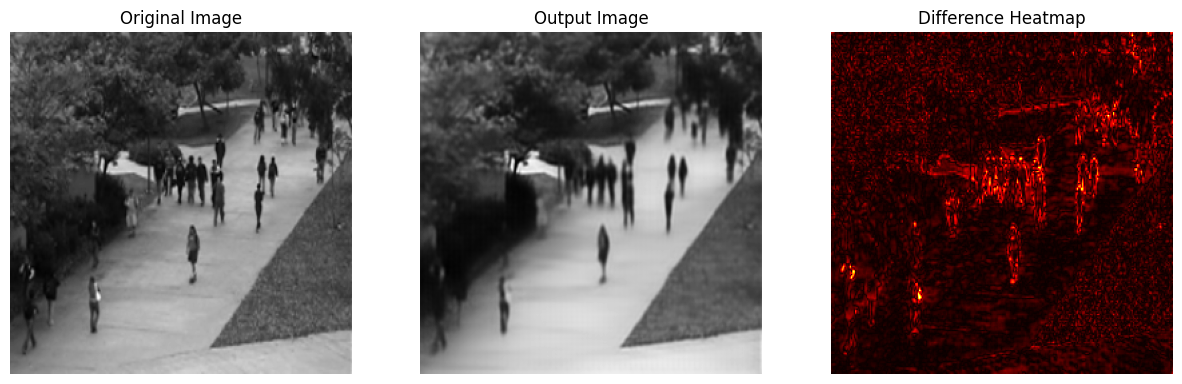

In [114]:

# Load one image for testing
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/' + next(files_iter)
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform =   transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((256, 256)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])
image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]
print(image_path)
print(image.shape)
 
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()



In [117]:
# Data preprocessing
# Data preprocessing
augment_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((256, 256)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])

# this is different from the training data since we need the average 
# of each 10 sliding window:
# First window: 0,1,2,3,4,5,6,7,8,9
# second window: 1,2,3,4,5,6,7,8,9,10,11 and so on     

def get_single_video_with_stride(images_dir, window_size=10, stride=1):
    images = sorted(glob.glob(os.path.join(images_dir, '*.tif')))
    sequences = []
    # if we are predicting LSTM images then should not multiply 
    for start in range(0, len(images), stride):
        window = images[start: start + window_size :stride]
        if (len(window) == window_size):
            sequence = [augment_transforms(default_loader(f)) for f in window]
            sequence_tensor = torch.stack(sequence, dim=0)
            sequences.append(sequence_tensor)
    return sequences
 
images_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005' 
sequences = get_single_video_with_stride(images_dir)
print(sequences[0].shape)

torch.Size([10, 1, 256, 256])


torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size

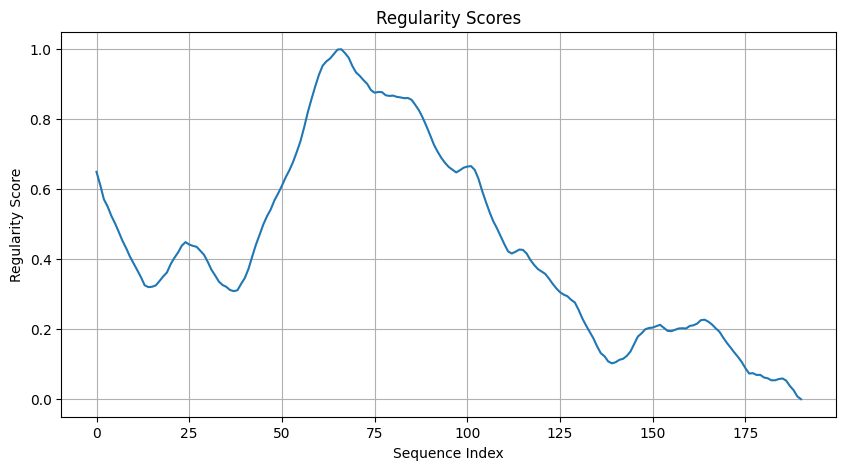

In [118]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate(sequences, model, device): 
    model.eval()
    regularity_scores = []
    l2_norms = []

    with torch.no_grad():
        # Process each sequence individually
        for sequence in sequences:
            original_image = sequence.unsqueeze(1).to(device)
            print(original_image.shape)
            output_image = model(original_image).to(device)
            # Compute L2 norm (Euclidean distance) between the original and output images
            l2_norm = torch.norm(original_image - output_image, p=2)
            l2_norms.append(l2_norm.item())
    print(len(l2_norms))
    # Normalize L2 norms to get regularity scores
    min_norm, max_norm = min(l2_norms), max(l2_norms)
    if max_norm - min_norm == 0:
        regularity_scores = [1.0] * len(l2_norms)
    else:
        regularity_scores = [1.0 - ((norm - min_norm) / (max_norm - min_norm)) for norm in l2_norms]

    return regularity_scores

# Assuming 'sequences' is a list of tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM()
model = nn.DataParallel(model) 
model.load_state_dict(torch.load('best_model_less.pth'))
model.to(device)

# Evaluate
eval_scores = evaluate(sequences, model, device)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(eval_scores)  # Line plot
plt.title('Regularity Scores')
plt.xlabel('Sequence Index')
plt.ylabel('Regularity Score')
plt.grid(True)
plt.show()


In [81]:
import torch
import numpy as np

def evaluate(sequences, model, device, batch_size=4): 
    model.eval()
    
    # Assuming sequences is a list of tensors
    sz = len(sequences)
    reconstructed_sequences = []
    sequences_reconstruction_cost = []

    with torch.no_grad():
        # Process the sequences in batches
        for i in range(0, sz, batch_size):
            batch = sequences[i:i+batch_size]
            batch = torch.stack(batch).to(device)
            print(batch.shape)

            # Predict the reconstructed batch
            reconstructed_batch = model(batch)
            reconstructed_sequences.extend(reconstructed_batch.cpu().numpy())

    # Calculate reconstruction cost for each sequence
    print(len(reconstructed_sequences))
    for original, reconstructed in zip(sequences, reconstructed_sequences):
        cost = np.linalg.norm(np.subtract(original, reconstructed))
        print(cost)
        sequences_reconstruction_cost.append(cost)

    # Normalize scores
    min_cost = np.min(sequences_reconstruction_cost)
    max_cost = np.max(sequences_reconstruction_cost)
    sa = (sequences_reconstruction_cost - min_cost) / max_cost
    sr = 1.0 - sa

    return sr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model 
model = ConvLSTM()
model = nn.DataParallel(model) 
model.load_state_dict(torch.load('best_model_less.pth'))
model.to(device) 
model.eval()

eval = evaluate(sequences, model, device, batch_size=4)
print(len(eval))


torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size([4, 10, 1, 256, 256])
torch.Size

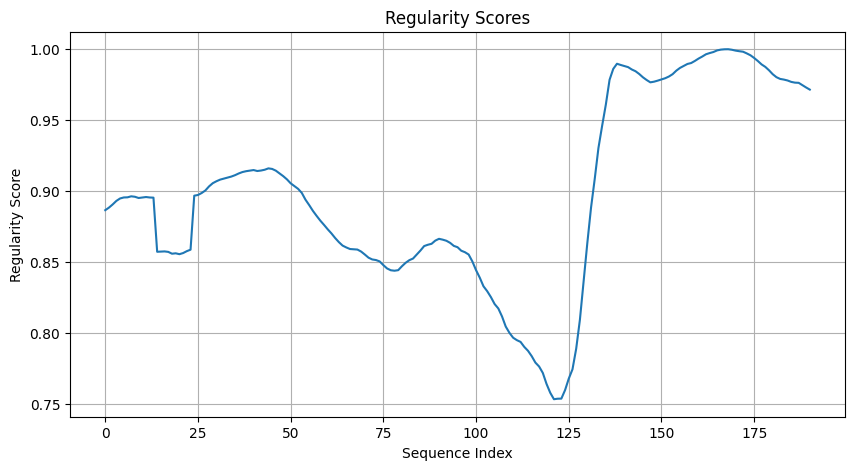

In [77]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(eval)  # Line plot
plt.title('Regularity Scores')
plt.xlabel('Sequence Index')
plt.ylabel('Regularity Score')
plt.grid(True)
plt.show()